# COMP 9444 Final Project
## Toxic text Classification

### In this notebook, we will perform muticlass classification on the dataset's oroginal lables

In recent years, online hate or offensive comments have proliferated on social media platforms and online discussions. It only takes one toxic word in online forums and social platforms to sour an online discussion on the web. Toxic comments are harming all social platforms.

Thus it is essential to automatically detect and warn of toxic comments on social platforms and flag them for removal. In response, our project attempts to build two models to detect different toxicity types, each of which performs binary and multi-class classification. We first fine-tuned the pre-trained BERT model on the comments dataset from the Wikipedia discussion page editor. And then, we proposed a bi-direction LSTM model to approach the performance of our pre-trained Bert model. We observed that the pre-trained model is not better than the simple model in all metrics.


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os

Our data cleaning will replace nonsense symbols like '\n' '\r' and etc. with spaces.

We delete website URLs since this content is not related to our task.

We also want to replace a large string of repeating characters as one string.Without this data cleaning, the max length of comment text is 1411. After data cleaning, the max length will become 265.

Drop rows in test set which has '-1' value.

In [2]:
def data_cleaning(text):
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = text.strip(' ')

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

Our data comes from: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In this project, we adopt a real-world dataset: jigsaw-toxic- comment from Kaggle, which is a collection of Wikipedia comments labelled manually for toxic behaviour 1. The toxic labels are in 6 categories which are toxic, severe toxic, obscene, threat, insult and identity hate.
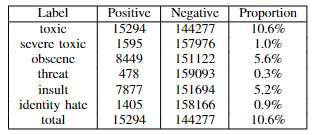

In [3]:
data_folder_path = './data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

In [5]:
toxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]
non_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]

df_o = df.copy()

In [6]:
ids_to_drop = []
for i in range(len(test_df)):
    if test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1:
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)
test_df.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding I think very highl...,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,Dear god this site is horrible,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,Somebody will invariably try to add Religion R...,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,It says it even in Binghamton University Unive...,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,Before adding a new product to the list make s...,00059ace3e3e9a53,0,0,0,0,0,0


## Exploratory Data Analysis

([<matplotlib.patches.Wedge at 0x7f06d2d3c160>,
 [Text(-1.0443548066304753, 0.3454316688837642, 'clean'),
  Text(1.0443548389721178, -0.34543157110420913, 'toxic')],
 [Text(-0.5696480763438956, 0.18841727393659866, '89.8%'),
  Text(0.5696480939847914, -0.18841722060229588, '10.2%')])

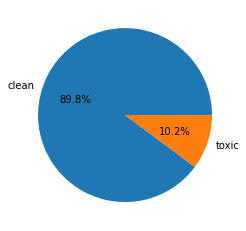

In [8]:
#percentage of clean comments
plt.pie([len(df['comment_text']) - len(toxic_df['comment_text']), len(toxic_df['comment_text'])], labels=['clean', 'toxic'], autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f06bad85670>,
 [Text(0.2205229793508023, 1.0776686019265134, 'toxic'),
  Text(-1.0627685713534702, 0.28376568457673707, 'severe_toxic'),
  Text(-0.88354481837012, -0.655246941184247, 'obscene'),
  Text(-0.1465638198299719, -1.0901922063181555, 'threat'),
  Text(0.6339460365091164, -0.8989507343533251, 'insult'),
  Text(1.0913128295372536, -0.1379721279367442, 'identity_hate')],
 [Text(0.12028526146407398, 0.5878192374144617, '43.6%'),
  Text(-0.5796919480109837, 0.15478128249640202, '4.5%'),
  Text(-0.48193353729279265, -0.35740742246413465, '24.1%'),
  Text(-0.0799439017254392, -0.5946502943553574, '1.4%'),
  Text(0.3457887471867907, -0.49033676419272265, '22.4%'),
  Text(0.5952615433839564, -0.0752575243291332, '4.0%')])

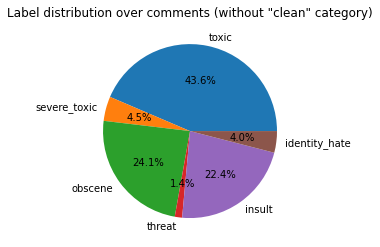

In [12]:
#percentages of each labels
plt.title('Label distribution over comments (without "clean" category)')
plt.pie([len(df[df['toxic'] == 1]), len(df[df['severe_toxic'] == 1]), len(df[df['obscene'] == 1]), len(df[df['threat'] == 1]), len(df[df['insult'] == 1]), len(df[df['identity_hate'] == 1])], labels=classes, autopct='%1.1f%%')

Such dominance of instance-rich (or head) classes throughout the training process is a typical problem when learning from the imbalanced dataset. The classification model often performs better on head classes, but its performance is noticeably poorer, for instance-scarce (or tail) classes. So we need find some approaches to enhance the classification performance of the tail classes, such as 'severe_toxic', ' threat' and 'identity_hate'.

## Load pre-trained word vectors
For the LSTM model, we choose GloVe’s pre-trained word vectors trained on Twitter tweets with an output vector size of 200 as our word embedding as tweets have similar properties to our dataset. 

In [11]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [12]:
from torchtext.vocab import GloVe, vocab

unk_token = "<pad>"
unk_index = 0

if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
    
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
# This is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

### Custom Dataloader with pre-padding

As all our sentences have different length, we pre-pad all the data to the maximum length of cleaned comments so that the LSTM can have a set input size.

In [13]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")

class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]
        diff = self.max_len - len(tokens)
        if diff > 0:
            tokens = [self.pad_token] * diff + tokens
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [14]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df_o, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)
print("Our current max length:", MAX_LEN)

Our current max length: 265


Long short term memory (LSTM) is an improved recurrent network architecture. Simple Recurrent Network (SRN) stores information close to the current input in a context layer. Compared with SRN, LSTM not only has hidden unit values to keep short-term state but also context unit values to keep long-term state with three gates.

Forget gate with current input and previously hidden unit value will help previous co-text unit value to keep important information and forget unimportant details. Update value is between -1 and 1, which is normalized from the information of new input, and then the input gate will determine what information will be stored in long-term context. This updated long-term context will involve in current hidden unit values with the output gate.

For our current text classification task, the predicted output is determined by both the previous input and the following input. In Bi-directional long short term memory (Bi-LSTM), one more LSTM layer with opposite directions will be added and connected to the same output. Therefore, it will keep information from the past and present with input flows in two directions and help to achieve better performance.


For the LSTM model, we choose GloVe’s pre-trained word vectors trained on Twitter tweets with an output vector size of
200 as our word embedding as tweets have similar properties to our dataset. After our data cleaning, we will pre-pad each
sequence to the maximum length of cleaned comments. We experimented with a wide range of hyper-parameters for better performance, 3 LSTM layers with 0.2 dropouts and 2 Linear layers before the output layer. Layer Normalization also will
be applied before each Linear layer.

In [18]:
class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    def forward(self, indices):

        embedded = self.embedding(indices.T)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [21]:
from torch.utils.data import DataLoader


BATCH_SIZE = 350

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

Let's use 3 GPUs!
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.00      0.00      0.00      3691
       threat       0.00      0.00      0.00       211
       insult       0.00      0.00      0.00      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.00      0.00      0.00     14498
    macro avg       0.00      0.00      0.00     14498
 weighted avg       0.00      0.00      0.00     14498
  samples avg       0.00      0.00      0.00     14498

Epoch: 0 Train_Loss: 0.15572375662036633 Train_Accuracy: 0.9628785848617554


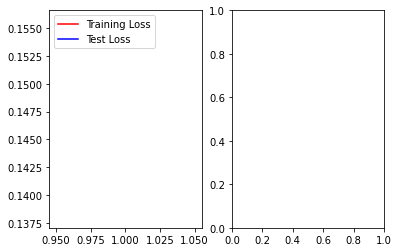

               precision    recall  f1-score   support

        toxic       0.70      0.21      0.32      6090
 severe_toxic       0.58      0.05      0.09       367
      obscene       0.71      0.20      0.31      3691
       threat       0.00      0.00      0.00       211
       insult       0.69      0.17      0.28      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.70      0.18      0.29     14498
    macro avg       0.45      0.11      0.17     14498
 weighted avg       0.65      0.18      0.28     14498
  samples avg       0.02      0.01      0.02     14498

Epoch: 1 Train_Loss: 0.11414681593969203 Train_Accuracy: 0.9656839966773987


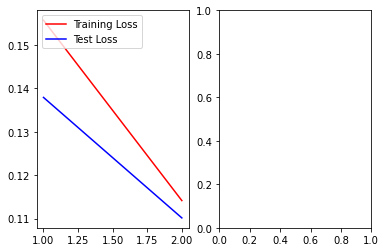

               precision    recall  f1-score   support

        toxic       0.69      0.31      0.43      6090
 severe_toxic       1.00      0.01      0.01       367
      obscene       0.73      0.30      0.43      3691
       threat       0.00      0.00      0.00       211
       insult       0.70      0.26      0.38      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.71      0.27      0.39     14498
    macro avg       0.52      0.15      0.21     14498
 weighted avg       0.67      0.27      0.38     14498
  samples avg       0.03      0.02      0.02     14498

Epoch: 2 Train_Loss: 0.09674828108236716 Train_Accuracy: 0.970058262348175


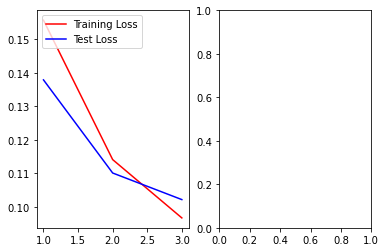

               precision    recall  f1-score   support

        toxic       0.71      0.36      0.47      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.71      0.40      0.51      3691
       threat       0.00      0.00      0.00       211
       insult       0.67      0.36      0.47      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.70      0.34      0.45     14498
    macro avg       0.35      0.19      0.24     14498
 weighted avg       0.64      0.34      0.44     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 3 Train_Loss: 0.08835684008929029 Train_Accuracy: 0.9722599983215332


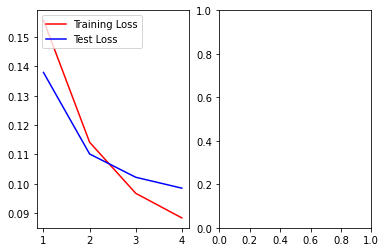

               precision    recall  f1-score   support

        toxic       0.77      0.35      0.48      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.75      0.39      0.52      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.35      0.47      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.75      0.33      0.46     14498
    macro avg       0.37      0.18      0.24     14498
 weighted avg       0.68      0.33      0.44     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 4 Train_Loss: 0.08372290198805563 Train_Accuracy: 0.9734935164451599


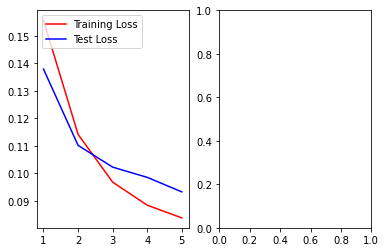

               precision    recall  f1-score   support

        toxic       0.70      0.44      0.54      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.74      0.44      0.55      3691
       threat       0.00      0.00      0.00       211
       insult       0.73      0.37      0.49      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.71      0.38      0.50     14498
    macro avg       0.36      0.21      0.26     14498
 weighted avg       0.65      0.38      0.48     14498
  samples avg       0.04      0.03      0.03     14498

Epoch: 5 Train_Loss: 0.07976942837826516 Train_Accuracy: 0.9744784235954285


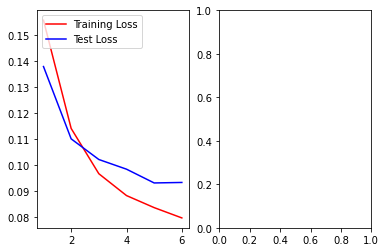

               precision    recall  f1-score   support

        toxic       0.78      0.38      0.51      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.81      0.40      0.54      3691
       threat       0.00      0.00      0.00       211
       insult       0.76      0.35      0.48      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.79      0.34      0.48     14498
    macro avg       0.39      0.19      0.25     14498
 weighted avg       0.72      0.34      0.46     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 6 Train_Loss: 0.07677118167313829 Train_Accuracy: 0.9750674962997437


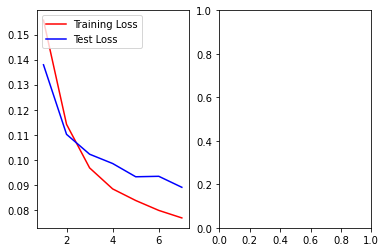

               precision    recall  f1-score   support

        toxic       0.70      0.48      0.57      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.75      0.48      0.58      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.41      0.52      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.72      0.42      0.53     14498
    macro avg       0.36      0.23      0.28     14498
 weighted avg       0.66      0.42      0.51     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 7 Train_Loss: 0.07455744145013261 Train_Accuracy: 0.9757328629493713


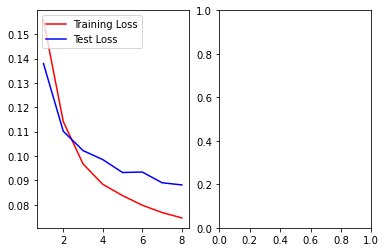

               precision    recall  f1-score   support

        toxic       0.72      0.47      0.57      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.78      0.47      0.58      3691
       threat       0.00      0.00      0.00       211
       insult       0.74      0.40      0.52      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.74      0.41      0.53     14498
    macro avg       0.37      0.22      0.28     14498
 weighted avg       0.68      0.41      0.51     14498
  samples avg       0.04      0.03      0.04     14498

Epoch: 8 Train_Loss: 0.07271127984450575 Train_Accuracy: 0.9761516451835632


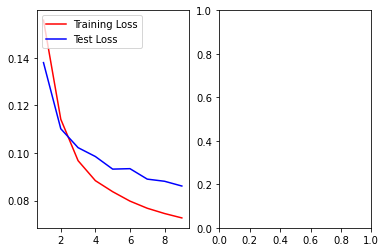

               precision    recall  f1-score   support

        toxic       0.74      0.48      0.58      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.78      0.48      0.59      3691
       threat       0.00      0.00      0.00       211
       insult       0.74      0.41      0.53      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.75      0.42      0.54     14498
    macro avg       0.38      0.23      0.28     14498
 weighted avg       0.68      0.42      0.52     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 9 Train_Loss: 0.07114358295343425 Train_Accuracy: 0.9765235185623169


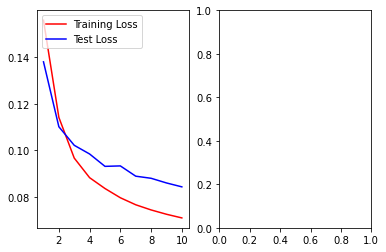

               precision    recall  f1-score   support

        toxic       0.69      0.52      0.59      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.76      0.51      0.61      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.45      0.55      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.71      0.45      0.55     14498
    macro avg       0.36      0.25      0.29     14498
 weighted avg       0.65      0.45      0.53     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 10 Train_Loss: 0.06929792404959076 Train_Accuracy: 0.9770634770393372


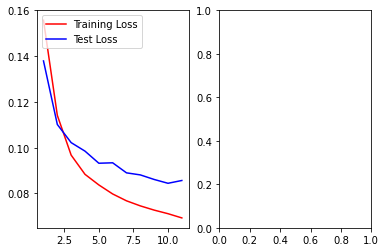

               precision    recall  f1-score   support

        toxic       0.69      0.52      0.59      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.76      0.51      0.61      3691
       threat       0.00      0.00      0.00       211
       insult       0.71      0.45      0.55      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.72      0.46      0.56     14498
    macro avg       0.36      0.25      0.29     14498
 weighted avg       0.65      0.46      0.54     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 11 Train_Loss: 0.06793603943987635 Train_Accuracy: 0.977435290813446


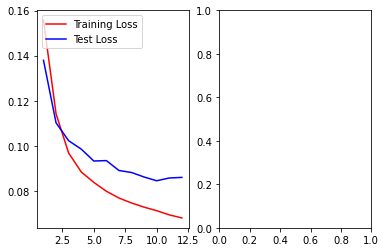

               precision    recall  f1-score   support

        toxic       0.72      0.51      0.60      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.76      0.52      0.62      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.45      0.55      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.73      0.45      0.56     14498
    macro avg       0.37      0.25      0.29     14498
 weighted avg       0.67      0.45      0.54     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 12 Train_Loss: 0.06701444871233482 Train_Accuracy: 0.9776901602745056


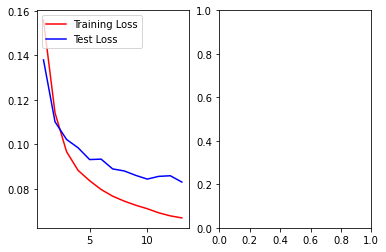

               precision    recall  f1-score   support

        toxic       0.65      0.57      0.61      6090
 severe_toxic       1.00      0.00      0.01       367
      obscene       0.70      0.57      0.63      3691
       threat       0.00      0.00      0.00       211
       insult       0.67      0.51      0.58      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.67      0.51      0.58     14498
    macro avg       0.50      0.28      0.30     14498
 weighted avg       0.64      0.51      0.56     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 13 Train_Loss: 0.06581531150527951 Train_Accuracy: 0.977843701839447


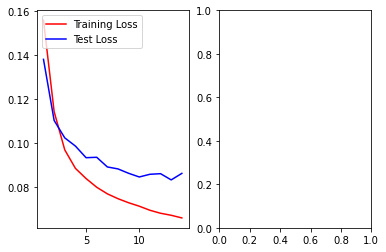

               precision    recall  f1-score   support

        toxic       0.73      0.53      0.61      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.76      0.53      0.63      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.47      0.57      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.73      0.47      0.57     14498
    macro avg       0.37      0.25      0.30     14498
 weighted avg       0.67      0.47      0.55     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 14 Train_Loss: 0.06487261517006054 Train_Accuracy: 0.9781549572944641


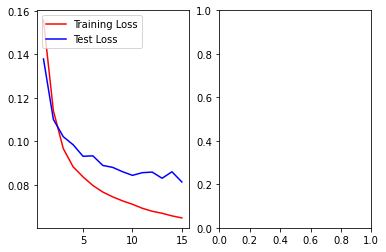

               precision    recall  f1-score   support

        toxic       0.77      0.49      0.60      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.80      0.50      0.61      3691
       threat       0.00      0.00      0.00       211
       insult       0.76      0.42      0.54      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.78      0.43      0.56     14498
    macro avg       0.39      0.24      0.29     14498
 weighted avg       0.71      0.43      0.54     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 15 Train_Loss: 0.06434570218583471 Train_Accuracy: 0.9782875776290894


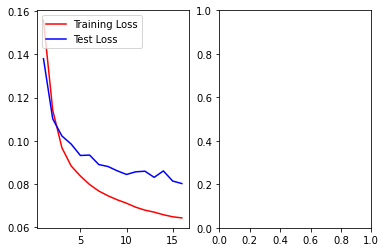

               precision    recall  f1-score   support

        toxic       0.67      0.58      0.62      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.69      0.60      0.64      3691
       threat       0.00      0.00      0.00       211
       insult       0.68      0.50      0.58      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.68      0.52      0.59     14498
    macro avg       0.34      0.28      0.31     14498
 weighted avg       0.62      0.52      0.56     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 16 Train_Loss: 0.06351272527357205 Train_Accuracy: 0.9785779714584351


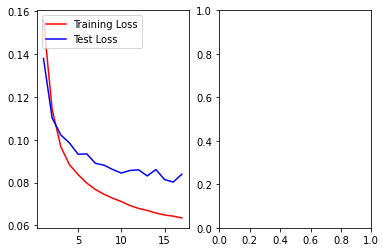

               precision    recall  f1-score   support

        toxic       0.76      0.51      0.61      6090
 severe_toxic       0.47      0.16      0.23       367
      obscene       0.78      0.53      0.63      3691
       threat       0.00      0.00      0.00       211
       insult       0.73      0.45      0.56      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.75      0.46      0.57     14498
    macro avg       0.46      0.27      0.34     14498
 weighted avg       0.70      0.46      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 17 Train_Loss: 0.06270879604281825 Train_Accuracy: 0.9787408709526062


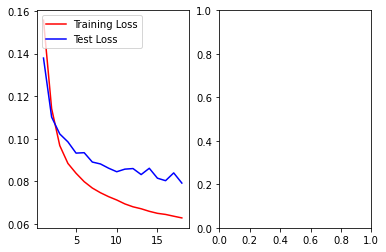

               precision    recall  f1-score   support

        toxic       0.67      0.58      0.62      6090
 severe_toxic       0.67      0.02      0.03       367
      obscene       0.78      0.55      0.64      3691
       threat       0.00      0.00      0.00       211
       insult       0.74      0.45      0.56      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.71      0.49      0.58     14498
    macro avg       0.48      0.27      0.31     14498
 weighted avg       0.67      0.49      0.56     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 18 Train_Loss: 0.0618322565988229 Train_Accuracy: 0.9789403676986694


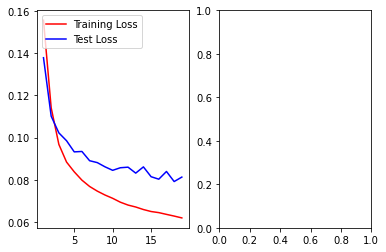

               precision    recall  f1-score   support

        toxic       0.73      0.54      0.62      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.77      0.54      0.64      3691
       threat       0.00      0.00      0.00       211
       insult       0.73      0.47      0.57      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.74      0.48      0.58     14498
    macro avg       0.37      0.26      0.30     14498
 weighted avg       0.67      0.48      0.56     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 19 Train_Loss: 0.06149564091148868 Train_Accuracy: 0.9789592027664185


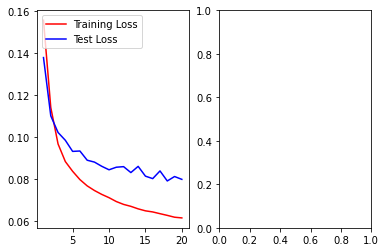

               precision    recall  f1-score   support

        toxic       0.69      0.57      0.63      6090
 severe_toxic       0.53      0.05      0.09       367
      obscene       0.77      0.56      0.65      3691
       threat       0.00      0.00      0.00       211
       insult       0.74      0.45      0.56      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.72      0.49      0.59     14498
    macro avg       0.46      0.27      0.32     14498
 weighted avg       0.68      0.49      0.56     14498
  samples avg       0.05      0.04      0.04     14498

Epoch: 20 Train_Loss: 0.06049084883150563 Train_Accuracy: 0.9792338609695435


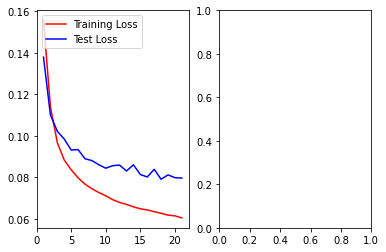

KeyboardInterrupt: 

In [27]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
for cls in classes:
    w = len(df) /df[cls].sum()
    weights.append(w)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.0001)

epochs = 50

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e % 3000 == 0 and e != 0:
        torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(e))

    # Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=classes)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()
